In [25]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [26]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [27]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [28]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [29]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [30]:
# [0,1,2] の順列を計算
permutations = list(itertools.permutations([0, 1, 2]))

# 6通りの組み合わせを生成
filtered_combinations = [(perm, perm) for perm in permutations]

# 最適化のためのobjective関数
def objective(trial, perm):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', 0.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 120.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm in permutations:
    print(f"Evaluating combination: perm1={perm}, perm2={perm}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm}, perm2={perm}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
        k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

        optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [k4]:
                    param.data = torch.clamp(param.data, 0.0, 10.0)
                for param in [t1, t2]:
                    param.data = torch.clamp(param.data, 0.0, 180.0)
                for param in [p1]:
                    param.data = torch.clamp(param.data, -180.0, 180.0)
                for param in [p2]:
                    param.data = torch.clamp(param.data, 0.0, 120.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm, perm)

        print(f"Finished training for combination: perm1={perm}, perm2={perm}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-11-22 13:32:36,491] A new study created in memory with name: no-name-0c9446a6-4457-448b-80de-aab74dcf4e50
[I 2024-11-22 13:32:36,620] Trial 0 finished with value: 212.6051483154297 and parameters: {'k1': -4.315465448286573, 'k2': -2.5170719315031125, 'k3': 4.6163727442546545, 'k4': 0.11190716727861649, 't1': 18.25423021511773, 'p1': 70.81816809694632, 't2': 106.3419797674084, 'p2': 65.7878635014212}. Best is trial 0 with value: 212.6051483154297.
[I 2024-11-22 13:32:36,676] Trial 1 finished with value: 395.1782531738281 and parameters: {'k1': 6.997024448436182, 'k2': 0.8240201590599483, 'k3': 0.11220681186388859, 'k4': 8.088189844716357, 't1': 89.36143887299178, 'p1': -105.36387728342667, 't2': 49.895200859468574, 'p2': 89.04403865752971}. Best is trial 0 with value: 212.6051483154297.


Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-22 13:32:36,770] Trial 2 finished with value: 507.2554626464844 and parameters: {'k1': 7.929292946523272, 'k2': 3.714320472090515, 'k3': 8.323462849588779, 'k4': 2.375051416802345, 't1': 122.54117024543774, 'p1': -84.54495208540406, 't2': 51.66308019576016, 'p2': 70.64094364834757}. Best is trial 0 with value: 212.6051483154297.
[I 2024-11-22 13:32:36,919] Trial 3 finished with value: 243.32656860351562 and parameters: {'k1': -2.5375411242433943, 'k2': 2.6177967853525494, 'k3': -8.765939938059216, 'k4': 1.9391045838192222, 't1': 2.836691154977564, 'p1': 8.244490483578005, 't2': 94.98142407920855, 'p2': 17.59819426046203}. Best is trial 0 with value: 212.6051483154297.
[I 2024-11-22 13:32:36,977] Trial 4 finished with value: 219.8113250732422 and parameters: {'k1': -1.7286534822178332, 'k2': -9.254025731519695, 'k3': -3.9692717793945587, 'k4': 1.5519615212720517, 't1': 60.85353472517064, 'p1': 78.6753426148124, 't2': 81.39761701888416, 'p2': 8.493617883760226}. Best is trial 

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-22 13:33:14,836] A new study created in memory with name: no-name-ded4dcbc-86d3-4ac4-af16-79a3ad60e7ab
[I 2024-11-22 13:33:14,892] Trial 0 finished with value: 225.08705139160156 and parameters: {'k1': -0.25314814154402043, 'k2': -3.081873040185396, 'k3': -4.516145262606168, 'k4': 5.673096649433646, 't1': 33.30443650311085, 'p1': -162.4796316101976, 't2': 26.19331403150945, 'p2': 105.13373491604396}. Best is trial 0 with value: 225.08705139160156.
[I 2024-11-22 13:33:14,948] Trial 1 finished with value: 233.45860290527344 and parameters: {'k1': -2.1105340861291477, 'k2': 1.3910864261695721, 'k3': -6.949147375601392, 'k4': 0.4605235101295291, 't1': 0.6325393481756048, 'p1': 23.244461527875103, 't2': 175.929043560327, 'p2': 67.48064432964574}. Best is trial 0 with value: 225.08705139160156.
[I 2024-11-22 13:33:15,001] Trial 2 finished with value: 353.46099853515625 and parameters: {'k1': -6.402724225552747, 'k2': 2.9438148360623817, 'k3': 5.18833346273831, 'k4': 9.454958230138

Epoch 0 Loss is 45.28071594238281, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-22 13:33:15,106] Trial 3 finished with value: 92.77400207519531 and parameters: {'k1': -1.8788306202107545, 'k2': -0.02482669890683553, 'k3': -0.9372559055855163, 'k4': 3.100221451288764, 't1': 141.49779698083276, 'p1': -132.70491088895272, 't2': 147.31488112336396, 'p2': 73.39684510134084}. Best is trial 3 with value: 92.77400207519531.
[I 2024-11-22 13:33:15,165] Trial 4 finished with value: 554.270751953125 and parameters: {'k1': 8.24294141563064, 'k2': 6.383947063026277, 'k3': 0.5752684064235396, 'k4': 3.7012573983978134, 't1': 49.36238096435448, 'p1': -141.76257771929826, 't2': 70.58745879823392, 'p2': 34.810943185279534}. Best is trial 3 with value: 92.77400207519531.
[I 2024-11-22 13:33:15,222] Trial 5 finished with value: 427.5036926269531 and parameters: {'k1': 9.115991238367709, 'k2': -2.402747528403264, 'k3': 2.7270448474641213, 'k4': 5.031019244507744, 't1': 125.33443223799412, 'p1': 147.30222401498048, 't2': 92.18409460154925, 'p2': 79.94001488720691}. Best is t

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 27.406024932861328
Parameters: k1=-6.428094863891602, k2=-7.8589324951171875, k3=0.7900965809822083, k4=7.284904479980469, k5=0.0, k6=0.0, t1=49.67256546020508, p1=-90.819091796875, t2=166.51626586914062, p2=19.066402435302734
Epoch 100, Loss: 16.253772735595703
Parameters: k1=-4.795663356781006, k2=-4.3039703369140625, k3=0.5082551836967468, k4=8.016234397888184, k5=0.0, k6=0.0, t1=56.846954345703125, p1=-97.99125671386719, t2=159.90997314453125, p2=20.727449417114258
Epoch 200, Loss: 4.710239887237549
Parameters: k1=-7.551122188568115, k2=-0.1878371685743332, k3=0.24451032280921936, k4=8.10835075378418, k5=0.0, k6=0.0, t1=71.98530578613281, p1=-98.40396118164062, t2=163.35516357421875, p2=4.533716201782227
Epoch 300, Loss: 0.8780637979507446
Parameters: k1=-8.251768112182617, k2=0.7674838304519653, k3=0.07327660173177719, k4=8.541069984436035, k5=0.0, k6=0.0, t1=80.80021667480469, p1=-93.08453369140625

[I 2024-11-22 13:35:49,586] A new study created in memory with name: no-name-99b96e3b-13a4-4846-ba56-ce295c9e5d85
[I 2024-11-22 13:35:49,675] Trial 0 finished with value: 172.04461669921875 and parameters: {'k1': -1.0317570248983703, 'k2': 1.6152362261053064, 'k3': -9.185159014579101, 'k4': 1.0147144028434052, 't1': 104.03639926442123, 'p1': -160.3540038100724, 't2': 27.993687789640337, 'p2': 71.5058371663904}. Best is trial 0 with value: 172.04461669921875.
[I 2024-11-22 13:35:49,736] Trial 1 finished with value: 109.89637756347656 and parameters: {'k1': 1.5214585772877136, 'k2': -3.9912318264163327, 'k3': -5.328453662850155, 'k4': 5.969312501851883, 't1': 165.1713175209722, 'p1': -20.729964026354622, 't2': 29.186528546593628, 'p2': 106.79926950747121}. Best is trial 1 with value: 109.89637756347656.


Loss increased at epoch 1004. Stopping training.
Best params during epoch training: {'k1': -8.568756103515625, 'k2': 1.1430820226669312, 'k3': -0.0004623926943168044, 'k4': 8.827425956726074, 'k5': 0.0, 'k6': 0.0, 't1': 89.90701293945312, 'p1': -90.02790832519531, 't2': 167.98780822753906, 'p2': 0.0}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-22 13:35:49,868] Trial 2 finished with value: 531.0296020507812 and parameters: {'k1': -3.431744060793413, 'k2': 9.661254481373597, 'k3': 5.864418399302746, 'k4': 4.355053622504302, 't1': 55.590395355678645, 'p1': 55.873128067320636, 't2': 143.5162406149696, 'p2': 2.137409568784232}. Best is trial 1 with value: 109.89637756347656.
[I 2024-11-22 13:35:49,928] Trial 3 finished with value: 82.1497802734375 and parameters: {'k1': -8.184682987289605, 'k2': -4.993934953540286, 'k3': -2.830340382412868, 'k4': 6.279957228849059, 't1': 29.106140430108375, 'p1': 73.34627247106337, 't2': 31.3349903109559, 'p2': 69.46457797776756}. Best is trial 3 with value: 82.1497802734375.
[I 2024-11-22 13:35:50,000] Trial 4 finished with value: 127.74395751953125 and parameters: {'k1': -7.803375628829898, 'k2': -0.7675885075547662, 'k3': 7.474264998300672, 'k4': 2.288394116381982, 't1': 72.58796759860131, 'p1': -90.56157699905981, 't2': 115.56847473648894, 'p2': 56.577872167116695}. Best is trial 3

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0 Loss is 44.828765869140625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-22 13:36:29,080] Trial 2 finished with value: 173.93255615234375 and parameters: {'k1': -4.343991071577036, 'k2': -0.11324120045376063, 'k3': 1.6160381226231468, 'k4': 1.8987783180755746, 't1': 40.987617231380014, 'p1': -125.73661837094454, 't2': 51.17504055873523, 'p2': 106.21099227742603}. Best is trial 0 with value: 142.72369384765625.
[I 2024-11-22 13:36:29,143] Trial 3 finished with value: 458.7049560546875 and parameters: {'k1': 8.726451429375917, 'k2': -6.422806899264151, 'k3': 4.656527216499558, 'k4': 8.67488656446574, 't1': 163.45048825511944, 'p1': 165.71808329105363, 't2': 74.2231692720331, 'p2': 90.4728154426385}. Best is trial 0 with value: 142.72369384765625.
[I 2024-11-22 13:36:29,263] Trial 4 finished with value: 303.4745788574219 and parameters: {'k1': 6.707060558662924, 'k2': -7.837255348870247, 'k3': -4.037690599846733, 'k4': 9.048718662829724, 't1': 147.93913221020227, 'p1': 107.50869645363093, 't2': 128.77376668476222, 'p2': 97.24475285238694}. Best is t

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0 Loss is 41.43151092529297, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-22 13:37:07,532] Trial 2 finished with value: 129.16146850585938 and parameters: {'k1': -5.233876523486318, 'k2': -2.2521241604327003, 'k3': -8.890073008893175, 'k4': 2.373498911906858, 't1': 28.673738205233875, 'p1': -168.27673118583186, 't2': 58.716150838277294, 'p2': 98.9117047924315}. Best is trial 2 with value: 129.16146850585938.
[I 2024-11-22 13:37:07,595] Trial 3 finished with value: 204.2865753173828 and parameters: {'k1': -0.831377352130465, 'k2': 5.127869954820612, 'k3': 1.0066499946709264, 'k4': 4.306795459445939, 't1': 24.807919918559932, 'p1': 124.0873536961202, 't2': 57.753447195062336, 'p2': 35.679609608800924}. Best is trial 2 with value: 129.16146850585938.
[I 2024-11-22 13:37:07,656] Trial 4 finished with value: 492.87493896484375 and parameters: {'k1': 3.7861668865986235, 'k2': 9.851000582357305, 'k3': 6.914964713802519, 'k4': 2.3067343990525737, 't1': 2.876883372799386, 'p1': -97.31054988599107, 't2': 49.27601393435954, 'p2': 62.06716804998307}. Best is 

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 13.137012481689453
Parameters: k1=-7.420229911804199, k2=-1.0046483278274536, k3=1.389185905456543, k4=9.844786643981934, k5=0.0, k6=0.0, t1=103.45999145507812, p1=-149.89768981933594, t2=16.418447494506836, p2=108.02457427978516
Epoch 100, Loss: 0.5942904949188232
Parameters: k1=-8.148996353149414, k2=0.7111673355102539, k3=0.06514328718185425, k4=8.598691940307617, k5=0.0, k6=0.0, t1=96.44580841064453, p1=-146.5162811279297, t2=12.817566871643066, p2=115.37218475341797
Epoch 200, Loss: 0.10289216041564941
Parameters: k1=-8.406841278076172, k2=0.9871934056282043, k3=0.02681335248053074, k4=8.728961944580078, k5=0.0, k6=0.0, t1=93.18473052978516, p1=-148.6565399169922, t2=12.40015983581543, p2=118.67705535888672
Epoch 300, Loss: 0.01613074727356434
Parameters: k1=-8.523279190063477, k2=1.099892497062683, k3=0.00842738151550293, k4=8.79079532623291, k5=0.0, k6=0.0, t1=91.47403717041016, p1=-149.4966278076

[I 2024-11-22 13:39:39,027] A new study created in memory with name: no-name-05ccce94-9f12-453a-979b-f64d1c51167a
[I 2024-11-22 13:39:39,152] Trial 0 finished with value: 373.9234924316406 and parameters: {'k1': 5.051145773627843, 'k2': 7.43810207380416, 'k3': -3.638183233572933, 'k4': 1.0971651101335689, 't1': 88.53485437509796, 'p1': -16.44899600700262, 't2': 138.4174307366654, 'p2': 118.73542627213041}. Best is trial 0 with value: 373.9234924316406.
[I 2024-11-22 13:39:39,212] Trial 1 finished with value: 219.71075439453125 and parameters: {'k1': 8.193782833364587, 'k2': -9.886303970511568, 'k3': 1.1225592445754096, 'k4': 5.926650775333081, 't1': 8.073022446145012, 'p1': 49.52492193113207, 't2': 135.37714613578254, 'p2': 40.251745408672114}. Best is trial 1 with value: 219.71075439453125.


Loss increased at epoch 965. Stopping training.
Best params during epoch training: {'k1': -8.571979522705078, 'k2': 1.1459816694259644, 'k3': 3.008577323271311e-06, 'k4': 8.829983711242676, 'k5': 0.0, 'k6': 0.0, 't1': 90.00064086914062, 'p1': -149.99977111816406, 't2': 12.000065803527832, 'p2': 120.0}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-22 13:39:39,274] Trial 2 finished with value: 248.377685546875 and parameters: {'k1': -9.499494605487143, 'k2': 0.25326668188283463, 'k3': -5.098764503882762, 'k4': 5.146585934944029, 't1': 155.24132130718763, 'p1': -97.97163250536866, 't2': 20.021076434536425, 'p2': 84.2054006843526}. Best is trial 1 with value: 219.71075439453125.
[I 2024-11-22 13:39:39,334] Trial 3 finished with value: 209.8475799560547 and parameters: {'k1': 6.614777029105461, 'k2': -4.785461002276055, 'k3': -1.6185146637367218, 'k4': 4.196011689041496, 't1': 83.02123531521623, 'p1': -69.94403193661617, 't2': 72.27148067226665, 'p2': 61.18421116018364}. Best is trial 3 with value: 209.8475799560547.
[I 2024-11-22 13:39:39,395] Trial 4 finished with value: 168.54116821289062 and parameters: {'k1': -5.238699141385732, 'k2': -4.0659125874788415, 'k3': 3.401791904360058, 'k4': 5.154844149762995, 't1': 129.4284065078451, 'p1': -177.8051850632482, 't2': 54.47686353446698, 'p2': 73.42068102508533}. Best is tria

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0 Loss is 38.44351577758789, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Global best Loss: 2.7967750337865027e-09
Global best params: {'k1': -8.571979522705078, 'k2': 1.1459816694259644, 'k3': 3.008577323271311e-06, 'k4': 8.829983711242676, 'k5': 0.0, 'k6': 0.0, 't1': 90.00064086914062, 'p1': -149.99977111816406, 't2': 12.000065803527832, 'p2': 120.0}
Global best combination: ((2, 0, 1), (2, 0, 1))


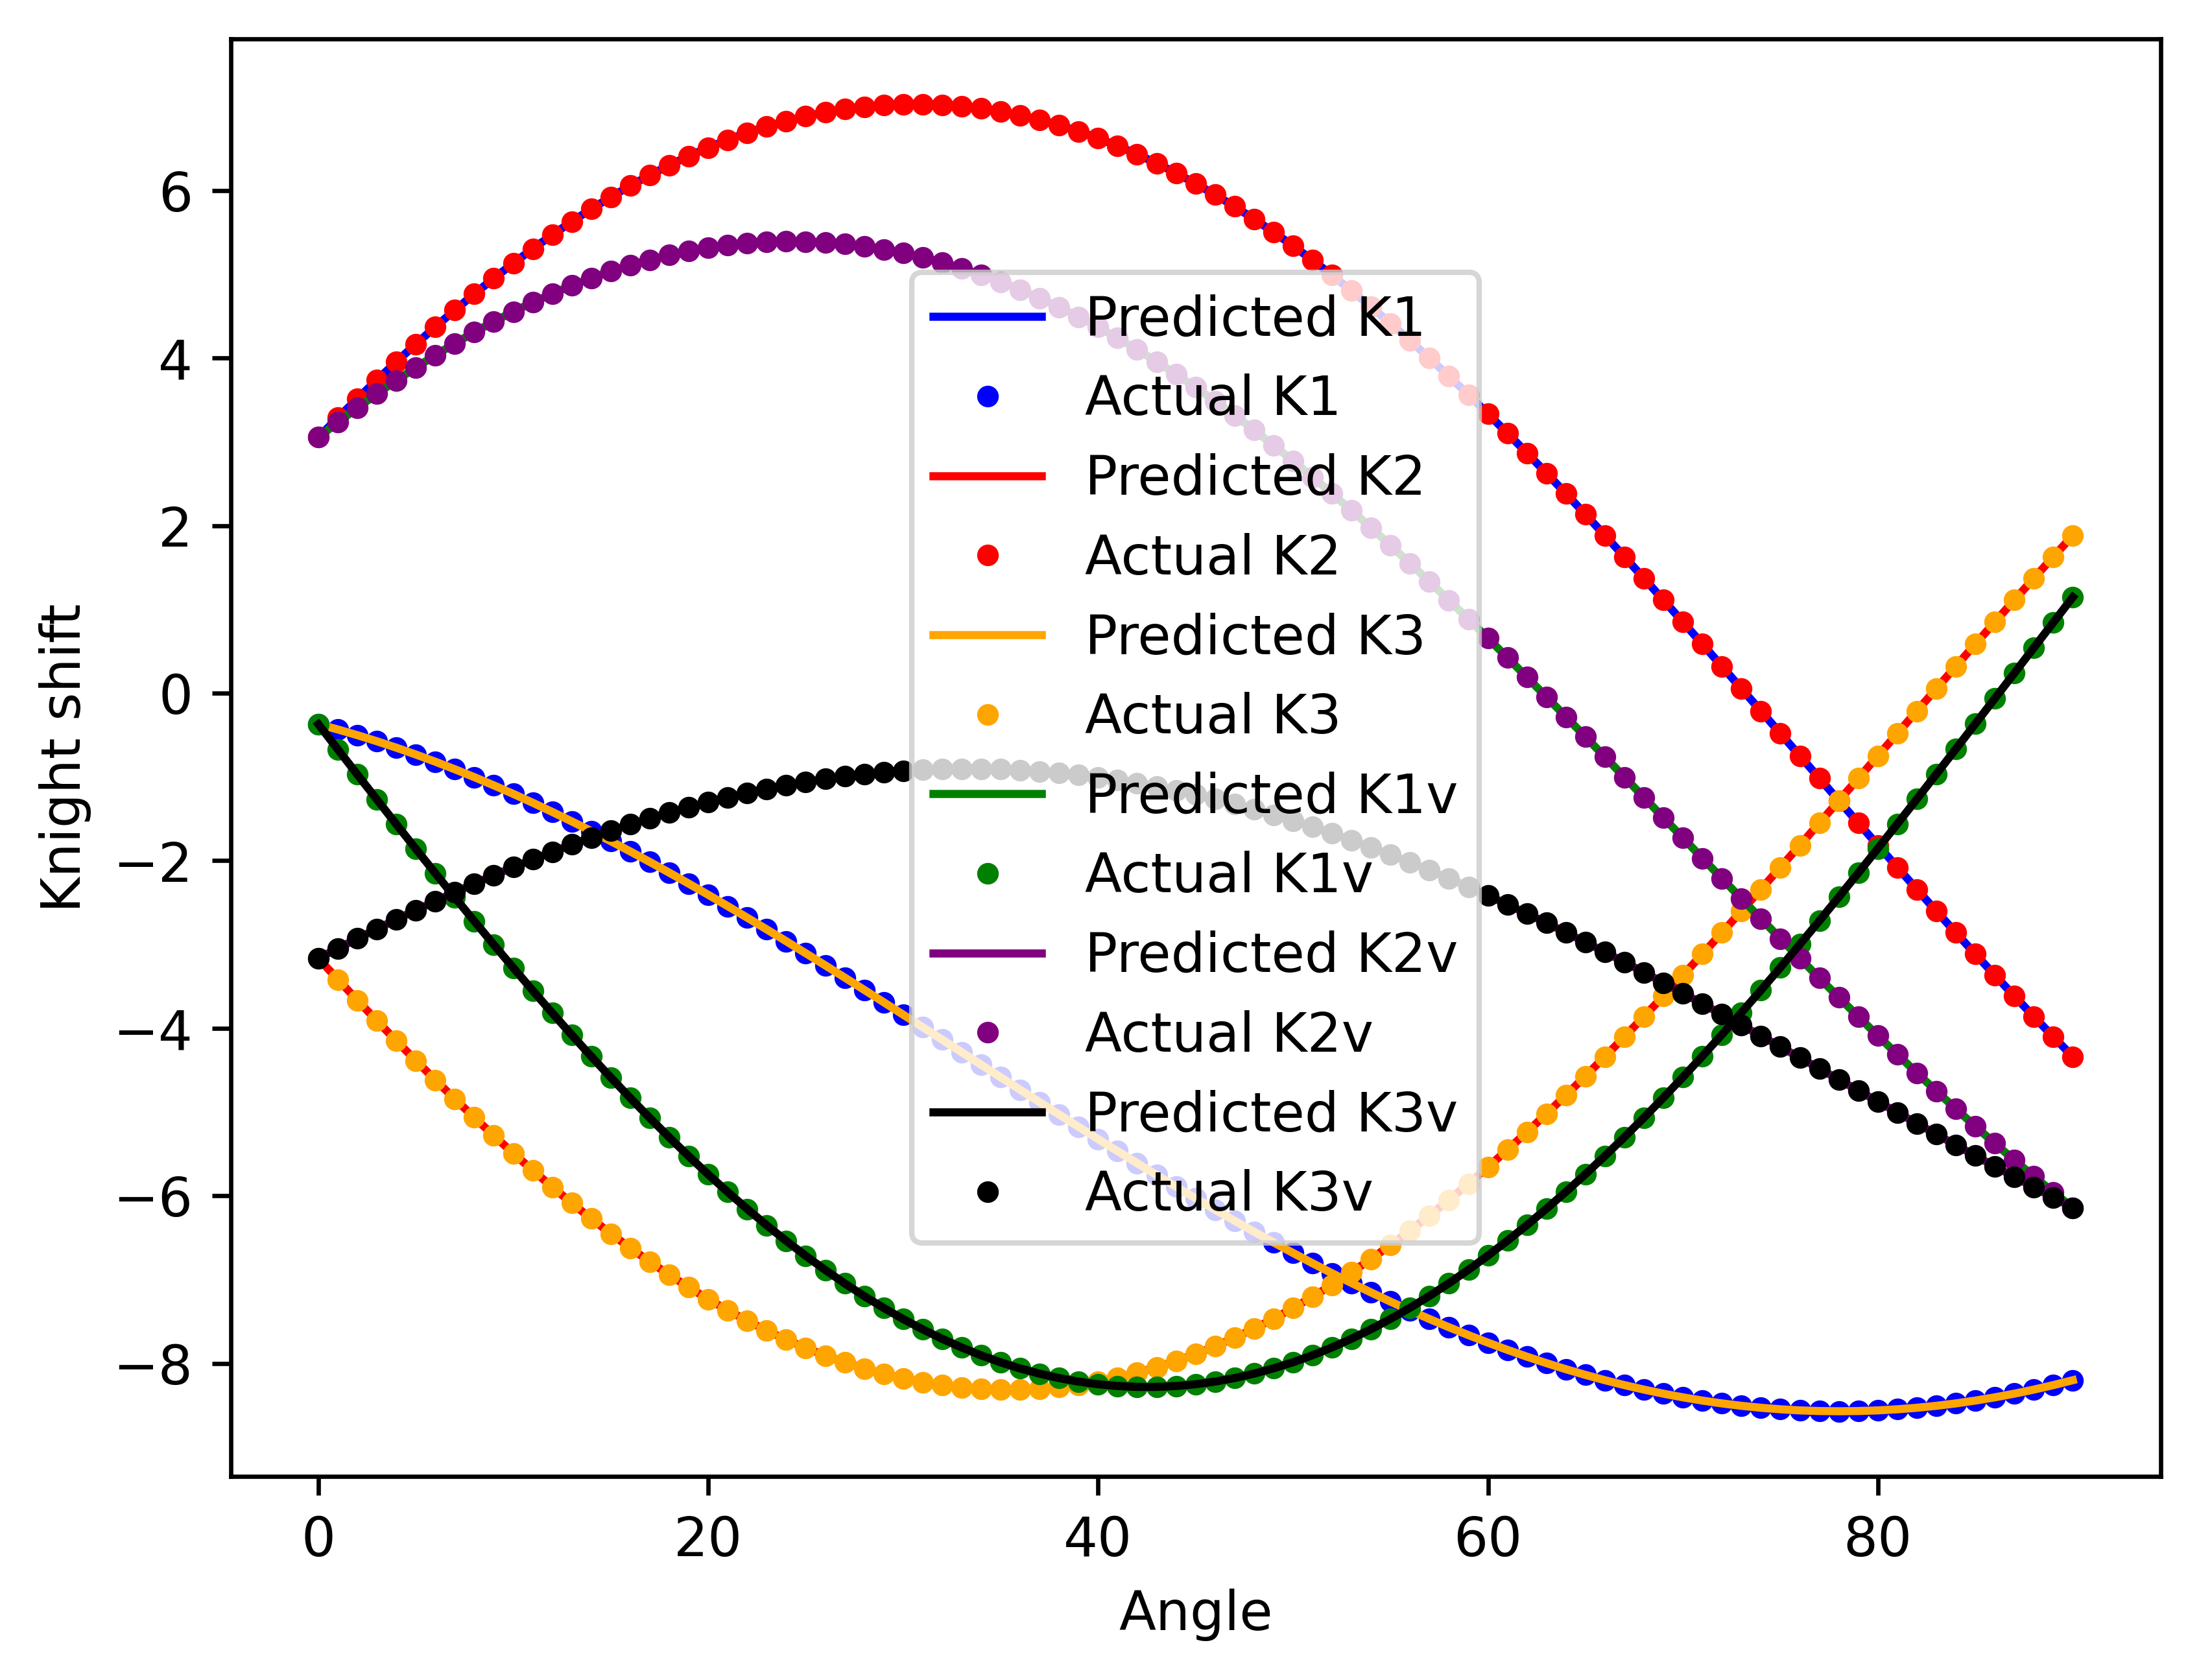

{'k1': -8.571979522705078, 'k2': 1.1459816694259644, 'k3': 3.008577323271311e-06, 'k4': 8.829983711242676, 'k5': 0.0, 'k6': 0.0, 't1': 90.00064086914062, 'p1': -149.99977111816406, 't2': 12.000065803527832, 'p2': 120.0}


In [31]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)

In [32]:
# パラメータをtorch.nn.Parameterに変換
k1 = torch.nn.Parameter(torch.tensor(global_best_params['k1'], dtype=torch.float32))
k2 = torch.nn.Parameter(torch.tensor(global_best_params['k2'], dtype=torch.float32))
k3 = torch.nn.Parameter(torch.tensor(global_best_params['k3'], dtype=torch.float32))
k4 = torch.nn.Parameter(torch.tensor(global_best_params['k4'], dtype=torch.float32))
k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
t1 = torch.nn.Parameter(torch.tensor(global_best_params['t1'], dtype=torch.float32))
p1 = torch.nn.Parameter(torch.tensor(global_best_params['p1'], dtype=torch.float32))
t2 = torch.nn.Parameter(torch.tensor(global_best_params['t2'], dtype=torch.float32))
p2 = torch.nn.Parameter(torch.tensor(global_best_params['p2'], dtype=torch.float32))

# 最適化アルゴリズムのセットアップ
optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-1)

# 特定の組み合わせ
perm1, perm2 = global_best_combination

# エポックごとのトレーニング
prev_loss = float('inf')
for epoch in range(300000):
    optimizer.zero_grad()

    # モデルを使って出力を計算
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    # シフト1とシフト2の計算
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    # ロスが増加した場合、トレーニングを終了
    if loss.item() > prev_loss:
        print(f"Loss increased at epoch {epoch}. Stopping training.")
        break

    # ロスが最小の場合のパラメータを保存
    prev_loss = loss.item()

    loss.backward()
    optimizer.step()

    # パラメータの範囲を制限
    with torch.no_grad():
        for param in [k1, k2, k3, k4]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
        for param in [t1, t2]:
                    param.data = torch.clamp(param.data, 0.0, 180.0)
        for param in [p1, p2]:
                    param.data = torch.clamp(param.data, -180.0, 180.0)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

Epoch 0, Loss: 2.7967750337865027e-09
Parameters: k1=-8.472521781921387, k2=1.244465947151184, k3=0.09938973188400269, k4=8.929287910461426, k5=0.0, k6=0.0, t1=89.90078735351562, p1=-150.0995635986328, t2=11.900764465332031, p2=120.09911346435547
Loss increased at epoch 1. Stopping training.


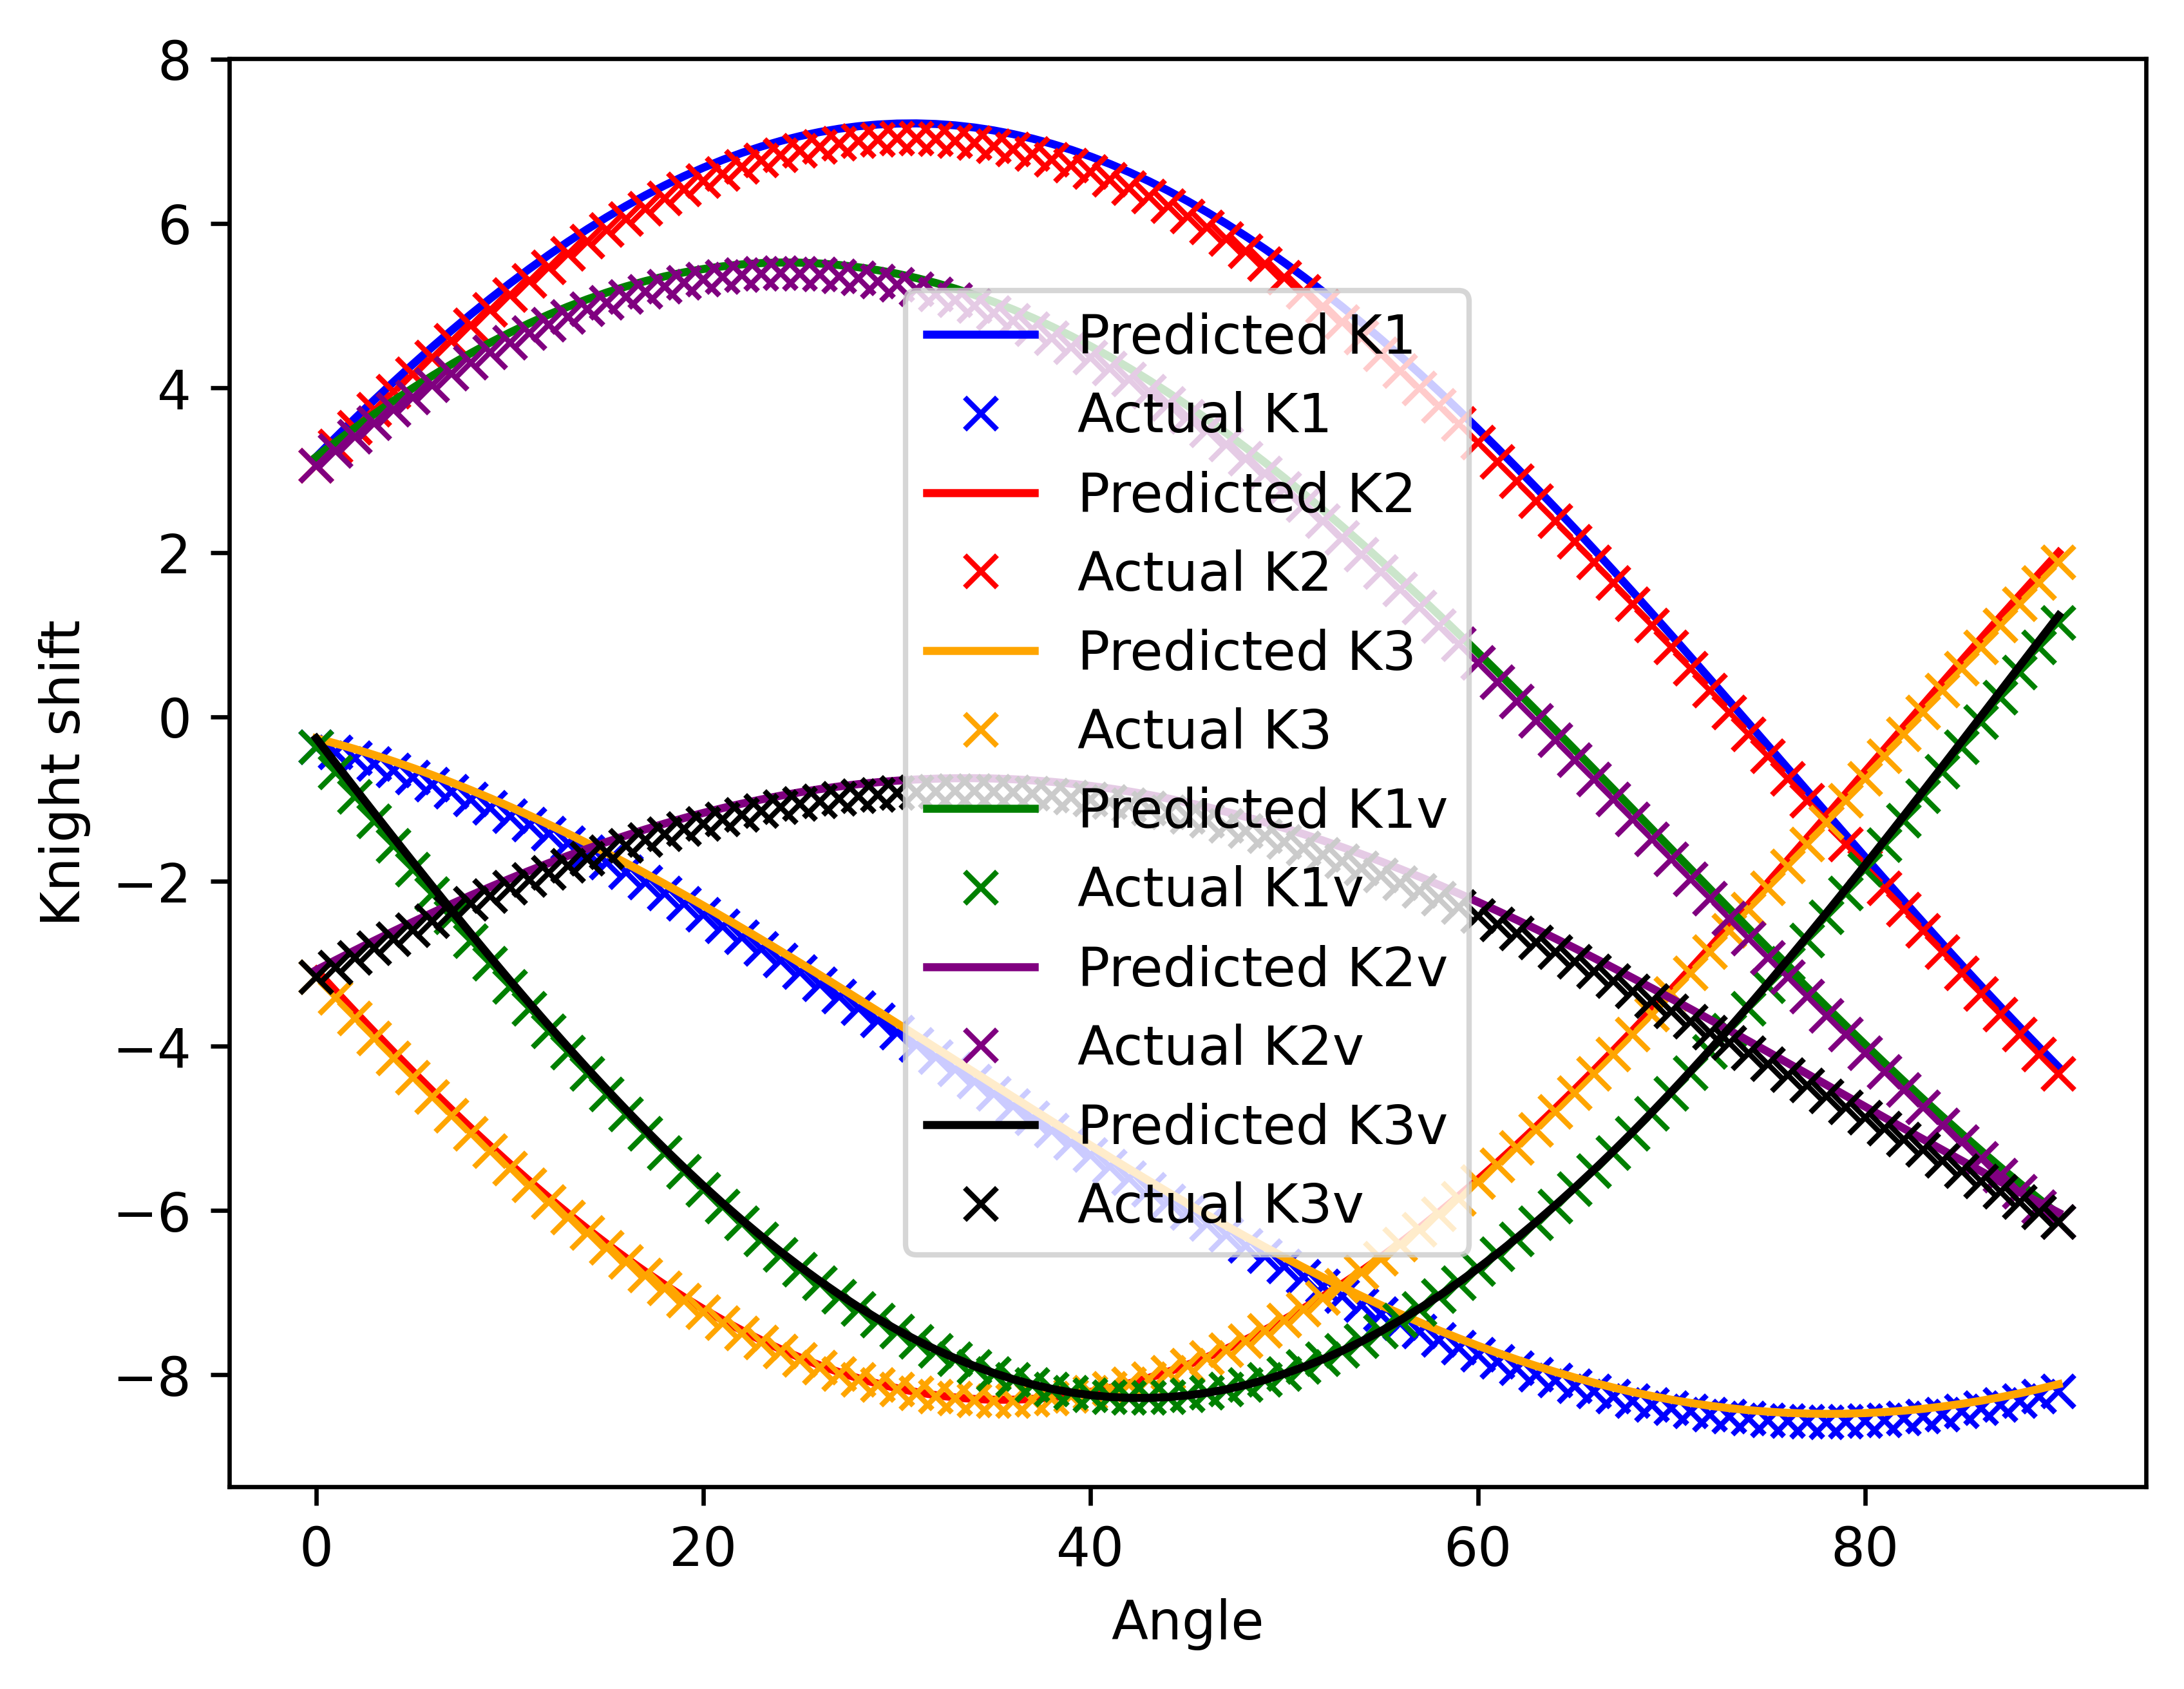

Parameters: k1=-8.472521781921387, k2=1.244465947151184, k3=0.09938973188400269, k4=8.929287910461426, k5=0.0, k6=0.0, t1=89.90078735351562, p1=-150.0995635986328, t2=11.900764465332031, p2=120.09911346435547


In [33]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(k1.item())
k2 = torch.tensor(k2.item())
k3 = torch.tensor(k3.item())
k4 = torch.tensor(k4.item())
k5 = torch.tensor(k5.item())
k6 = torch.tensor(k6.item())
t1 = torch.tensor(t1.item())
p1 = torch.tensor(p1.item())
t2 = torch.tensor(t2.item())
p2 = torch.tensor(p2.item())

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'x', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'x', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'x', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'x', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'x', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'x', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')